In [1]:
import scipy.constants as consts
from lib.AtomNumbers import QD, Rb87, State, TermEnergy, TransitionFrequency
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import sqlite3
import os.path
from sympy import *
from sympy.physics.wigner import clebsch_gordan, wigner_6j
import datetime
%matplotlib inline

In [2]:
states = []
n_min = 50
n_max = 150
l_max = 1 # stop at f
sI = State(97,2,2.5,2.5)
mj_total = 2*sI.mj

for n in range(n_min,n_max):
  for l in [sI.l-1,sI.l+1]:
    for j in np.arange(abs(l-0.5),l+1): # l+0.5 doesn't regiser the second j value
      for mj in np.arange(-j,j+0.5):
        s=State(n,l,j,mj)
        states.append([s, TransitionFrequency(Rb87,sI,s)])
          
print(len(states))

2000


### calculate forster defects

In [3]:
EnergyCut = 1e9 # only consider states within 1 Ghz
molecular_states = []

for s1 in states:
  for s2 in states:
    # molecular dissociation energy limit relative to the initial state
    molecular_energy = s1[1][0]+s2[1][0]
    if abs(molecular_energy) <= EnergyCut:
      if s1[0].mj + s2[0].mj == mj_total:
        molecular_states.append([(s1[0],s2[0]), molecular_energy])

print(len(molecular_states))

190


### radial matrix elements from the database

In [4]:
db_file = os.path.join('data','RMEdbs','Rb87.sqlite3') 
if not os.path.isfile(db_file):
  print("No database file found")

In [5]:
def RMEs(state, n_range, l2, j2):
  # assumes l2 >= l1, if not swap
  if int(l2) < state.l:
    if state.j == float(j2):
      j_index = 1
    elif float(j2) > int(l2):
      j_index = 2
    else:
      j_index = 0
    l_str = int(l2)*10 + state.l
      
  else: # otherwise do the normal order
    if state.j == float(j2):
      j_index = 1
    elif state.j > state.l:
      j_index = 2
    else:
      j_index = 0
    l_str = int(l2) + state.l*10

  js = ["jmjpm", "jpjpm", "jpjpp"][j_index]
  subs = (state.n, n_range[0], n_range[1])
  query = """SELECT n, {} FROM L{} WHERE np=? AND n>=? AND n<=?""".format(js, l_str)
  
  conn = sqlite3.connect(db_file)
  c = conn.cursor()
  return c.execute(query, subs)

In [6]:
def RME(state1, state2):
  # assumes l2 >= l1, if not swap
  if state2.l < state1.l:
    l_str = state2.l*10 + state1.l
    n1, l1, j1 = ( state2.n, state2.l, state2.j )
    n2, l2, j2 = ( state1.n, state1.l, state1.j )
    
  else: # otherwise do the normal order
    l_str = state2.l + state1.l*10
    n1, l1, j1 = ( state1.n, state1.l, state1.j )
    n2, l2, j2 = ( state2.n, state2.l, state2.j )

  if j1 == j2:
    j_index = 1
  elif j1 > l1:
    j_index = 2
  else:
    j_index = 0
  js = ["jmjpm", "jpjpm", "jpjpp"][j_index]
  subs = (n1, n2)
  query = """SELECT {} FROM L{} WHERE n=? AND np=? LIMIT 1""".format(js, l_str)
  
  conn = sqlite3.connect(db_file)
  c = conn.cursor()
  c.execute(query, subs)
  return c.fetchone()[0]

In [7]:
print(RME(State(12, 2, 1.5), State(11, 1, 1.5)))
print(RME(State(11, 1, 1.5), State(12, 2, 1.5)))
print(RME(State(11, 1, 0.5), State(12, 2, 1.5)))

-2.51450167632
-2.51450167632
-2.03519312761


### Angular Matrix Elements

#### We use a symbolic package to deal with the wigner symbols to avoid numerical errors

In [8]:
# p is -1, 0, 1
def AME(state1, state2, p):
  l1, j1, m1 = state1.angular_momentum()
  l2, j2, m2 = state2.angular_momentum()
  res =(-1)**int(j1+l2-0.5)*sqrt((2*j1+1)*(2*l1+1))
  res *= clebsch_gordan(j1, 1, j2, m1, p, m2)
  res *= clebsch_gordan(l1, 1, l2, 0, 0, 0)
  res *= wigner_6j(l1,0.5,j1,j2,1,l2)
  return res

In [9]:
N(AME(State(5,1,1.5,0.5),State(5,2,2.5,1.5),1))

0.489897948556636

In [10]:
AME(State(5,1,1.5,0.5),State(5,2,2.5,1.5),1)

0.282842712474619*sqrt(3)

### c_3 Coefficient Maker

In [11]:
GHz_um3_factor = 1e9*(1/(4*np.pi*consts.epsilon_0))*consts.e**2
GHz_um3_factor *= consts.physical_constants['Bohr radius'][0]**2/(2*np.pi*consts.hbar)
  
# returns the c3 coefficient for the two states
def c3(stateI1, stateI2, stateF1, stateF2):
  # electric dipole transitions
  if(abs(stateI1.l-stateF1.l) != 1):
    return 0
  if(abs(stateI2.l-stateF2.l) != 1):
    return 0
  
  p = stateF1.mj - stateI1.mj # -1,0,+1
  if abs(p)>1:
    return 0
  if stateI2.mj - stateF2.mj != p: # dmj = 0
    return 0
  
  a = AME(stateI1, stateF1, p)*RME(stateI1, stateF1)
  b = AME(stateI2, stateF2, -p)*RME(stateI2, stateF2)
  c = clebsch_gordan(1,1,2,p,-p,0)
  return N(-GHz_um3_factor*sqrt(6)*c*a*b)

In [12]:
s0=State(97,2,2.5,2.5)
sf1=State(99,1,1.5,1.5)
sf2=State(95,3,3.5,3.5)
c3(s0,s0,sf1,sf2)-21.7965 # check against older values

3.72430093520393e-6

In [13]:
s0=State(97,2,2.5,2.5)
sf1=State(98,1,1.5,1.5)
sf2=State(96,3,3.5,3.5)
c3(s0,s0,sf1,sf2)-61.1639 # check against older values

5.17366347452253e-6

### Build the Hamiltonian

In [14]:
dimension = len(molecular_states)+1 # add on the initial state
Hcoupling = np.zeros((dimension,dimension))
energies = np.zeros(dimension)
for i in xrange(dimension-1):
  ms = molecular_states[i]
  temp = c3(s0,s0,ms[0][0],ms[0][1])
  Hcoupling[i][-1] = temp
  Hcoupling[-1][i] = temp
  energies[i] = ms[1]*1e-9 # in GHz

In [15]:
def getReleventCouplings(couplings, forsters, r, ccut, ecut = 1):
    # get the center molecular state (energy is 0 by design)
    cindex = np.abs(forsters).argsort()[0]
    r3 = r**3
    # make the hamiltonian at r
    H=(np.divide(couplings, r3) + np.diag(forsters))
    # do the thing
    e, v = np.linalg.eig(H)
    v = np.asarray(v)
    # save the data that has coupling greater than ccut
    data = []
    for i in range(len(v)):
        if (abs(v[cindex][i]) >= ccut) and (abs(e[i]) <= ecut):
            data.append([ r, np.real(e[i]), (np.real(v[cindex][i]))**2, np.abs(v[:,i]).argsort()[-5:][::-1] ])
    
    return data #[ r(um), E(r) (GHz), overlap with center state, largest overlaps from basis states ]

#### verify at large R (100 um)

In [16]:
getReleventCouplings(Hcoupling, energies, 100, 0.001)

[[100,
  array(-3.8002538873498926e-08),
  0.99999982334140536,
  array([190,  96,  93,  92,  97])]]

#### Calculate blockade curves

In [17]:
data = []

In [18]:
r_start = 3
r_stop = 15
samples = 500
r_last = 0
for r in np.linspace(r_start,r_stop,samples):
    current_time = datetime.datetime.now().time()
    if int(r) > int(r_last):
      print(r)
      print(current_time.isoformat())
      r_last = r
    data = data + getReleventCouplings(Hcoupling, energies, r, 0.01, 1.0)

3.0
15:12:40.996319
4.01002004008
15:12:43.697956
5.02004008016
15:12:46.231068
6.00601202405
15:12:49.387223
7.01603206413
15:12:52.513072
8.00200400802
15:12:54.979574
9.0120240481
15:12:57.498908
10.0220440882
15:13:00.018108
11.0080160321
15:13:02.482754
12.0180360721
15:13:05.014878
13.004008016
15:13:07.474644
14.0140280561
15:13:10.271136
15.0
15:13:12.889713


In [19]:
mark_r = [0.20202, 0.40404, 0.606061, 0.808081, 1.0101, 1.21212, 1.41414, \
1.61616, 1.81818, 2.0202, 2.22222, 2.42424, 2.62626, 2.82828, 3.0303, \
3.23232, 3.43434, 3.63636, 3.83838, 4.0404, 4.24242, 4.44444, \
4.64646, 4.84848, 5.05051, 5.25253, 5.45455, 5.65657, 5.85859, \
6.06061, 6.26263, 6.46465, 6.66667, 6.86869, 7.07071, 7.27273, \
7.47475, 7.67677, 7.87879, 8.08081, 8.28283, 8.48485, 8.68687, \
8.88889, 9.09091, 9.29293, 9.49495, 9.69697, 9.89899, 10.101, 10.303, \
10.5051, 10.7071, 10.9091, 11.1111, 11.3131, 11.5152, 11.7172, \
11.9192, 12.1212, 12.3232, 12.5253, 12.7273, 12.9293, 13.1313, \
13.3333, 13.5354, 13.7374, 13.9394, 14.1414, 14.3434, 14.5455, \
14.7475, 14.9495, 15.1515, 15.3535, 15.5556, 15.7576, 15.9596, \
16.1616, 16.3636, 16.5657, 16.7677, 16.9697, 17.1717, 17.3737, \
17.5758, 17.7778, 17.9798, 18.1818, 18.3838, 18.5859, 18.7879, \
18.9899, 19.1919, 19.3939, 19.596, 19.798, 20.]
mark_B = [-10966.3, -1370.79, -406.16, -171.349, -87.7303, -50.7695, -31.971, \
-21.4175, -15.0414, -10.9642, -8.23635, -6.34261, -4.98687, -3.99069, \
-3.24218, -2.66872, -2.22181, -1.86818, -1.58454, -1.35422, -1.16507, \
-1.00814, -0.876692, -0.76563, -0.671032, -0.589863, -0.51975, \
-0.458827, -0.405612, -0.358925, -0.317818, -0.281522, -0.24941, \
-0.220963, -0.195746, -0.17339, -0.153577, -0.136026, -0.120493, \
-0.106757, -0.0946198, -0.0839036, -0.074448, -0.0661083, -0.0587547, \
-0.0522711, -0.0465538, -0.0415106, -0.0370599, -0.0331295, \
-0.0296559, -0.0265832, -0.0238624, -0.0214505, -0.01931, -0.017408, \
-0.0157157, -0.0142081, -0.0128632, -0.0116618, -0.0105871, \
-0.00962452, -0.00876107, -0.00798552, -0.00728798, -0.00665975, \
-0.00609318, -0.00558157, -0.00511896, -0.00470014, -0.00432048, \
-0.0039759, -0.00366277, -0.00337787, -0.00311837, -0.00288173, \
-0.00266568, -0.00246822, -0.00228756, -0.00212208, -0.00197036, \
-0.0018311, -0.00170316, -0.0015855, -0.0014772, -0.00137741, \
-0.00128538, -0.00120043, -0.00112194, -0.00104937, -0.000982209, \
-0.00092, -0.000862334, -0.000808835, -0.000759164, -0.000713011, \
-0.000670096, -0.00063016, -0.000592972]

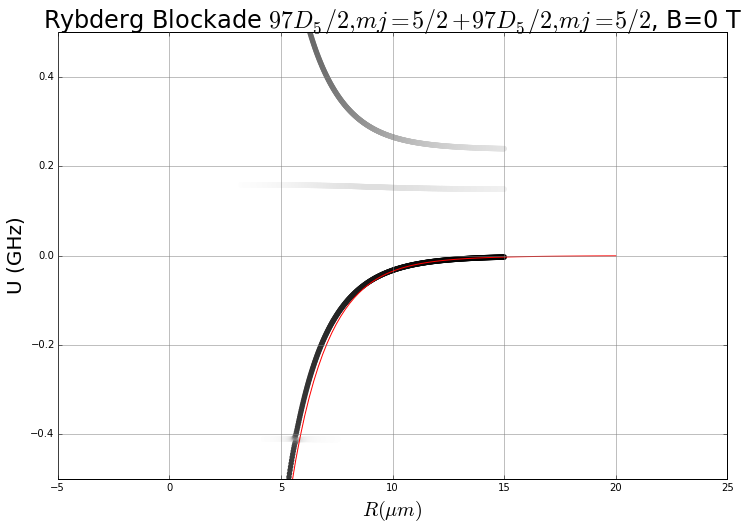

In [20]:
plt.figure(figsize=(12,8))

x =[]
x.append([ d[0] for d in data ])
x.append([ d[1] for d in data ])
x.append(np.real([ 1-sqrt(d[2]) for d in data ]))

idx = x[2].argsort()[::-1]
x[0] = [ x[0][i] for i in idx ]
x[1] = [ x[1][i] for i in idx ]
x[2] = [ x[2][i] for i in idx ]

plt.scatter(x[0], x[1], c=x[2], marker='o', s=30, vmax=1, vmin=0, linewidth=0, alpha=1)
plt.plot(mark_r,mark_B, color='r')

plt.gray()
plt.ylim(-0.5,0.5)

plt.grid(b=True, which='major', color='0.5', linestyle='-')
plt.grid(b=True, which='minor', color='0.75', linestyle='--')

plt.title('Rybderg Blockade ${}+{}$, B=0 T'.format(s0,s0), fontsize=24)
plt.xlabel('$R (\mu m)$', fontsize=20)
plt.ylabel('U (GHz)', fontsize=20)

#plt.savefig('MolecularResonances_B=370uT_97D52m52_97D52m52.pdf')
plt.show()